In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [10]:
l0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l0])
model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))
model.fit(dataset, epochs = 100)
print("Layer weights {}".format(l0.get_weights()))

Epoch 1/100
31/31 [==============================] - 1s 25ms/step - loss: 357.2369
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 132.4229
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 114.7203
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 108.3374
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 100.9265
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 99.3578
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 95.2682
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 93.5930
Epoch 9/100
31/31 [==============================] - 0s 13ms/step - loss: 91.9846
Epoch 10/100
31/31 [==============================] - 0s 12ms/step - loss: 89.1088
Epoch 11/100
31/31 [==============================] - 0s 14ms/step - loss: 86.6517
Epoch 12/100
31/31 [==============================] - 0s 14ms/step - loss: 81.1728
Epoch 13

31/31 [==============================] - 0s 12ms/step - loss: 45.5160
Epoch 100/100
31/31 [==============================] - 0s 12ms/step - loss: 45.0076
Layer weights [array([[-0.10341293],
       [ 0.03155851],
       [ 0.05430044],
       [ 0.0558494 ],
       [-0.07759885],
       [ 0.09634943],
       [-0.09796692],
       [ 0.03931501],
       [-0.02644422],
       [ 0.10064223],
       [-0.11669752],
       [ 0.10229264],
       [-0.10311135],
       [-0.01636648],
       [ 0.10059985],
       [ 0.06480108],
       [-0.0291304 ],
       [ 0.21183603],
       [ 0.26465613],
       [ 0.44075358]], dtype=float32), array([0.01739423], dtype=float32)]


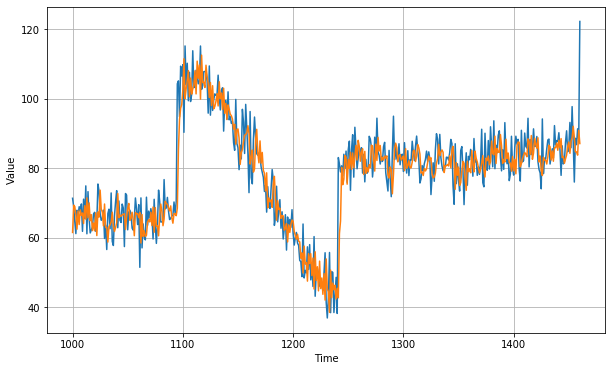

In [11]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.182315

In [13]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

49.112717